In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import MinMaxScaler


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/evan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# [Tutorial](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

## Load the Data 

In [39]:
df = pd.read_csv("csv/book_info_complete.csv")
df = df.dropna(axis=1)
df["Publication date"] = df["Publication date"].str[-4:].astype(int)
df = df.drop("Last updated", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 9 columns):
title               5816 non-null object
description         5816 non-null object
plot                5816 non-null object
csm_review          5816 non-null object
need_to_know        5816 non-null object
csm_rating          5816 non-null int64
Genre               5816 non-null object
Book type           5816 non-null object
Publication date    5816 non-null int64
dtypes: int64(2), object(7)
memory usage: 409.1+ KB


### Lower and remove stop words

In [40]:
columns = ['title', "description", "plot", "csm_review", "need_to_know"]

df = df.applymap(lambda x: x.lower() if type(x) == str else x)

df[columns] = df[columns].applymap(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [41]:
df.head()

,title,description,plot,csm_review,need_to_know,csm_rating,Genre,Book type,Publication date
0,third twin,gripping thriller skimps character development.,"twins ava alexa ""lexi"" rios live affluent sout...","third twin interesting, compelling premise: bo...",parents need know third twin murder mystery in...,12,mystery,fiction,2015
1,small damages,luminous story pregnant teen's summer spain.,"summer 1996, 18-year-old kenzie planned spend ...","could well minefield clichés nd preachiness, l...",parents need know small damages narrated pregn...,14,coming of age,fiction,2012
2,"school good evil, book 1",fractured fairy tale plenty twists fantasy fans.,best friends sophie agatha stolen away village...,school good evil run-of-the-mill fairy tale sp...,parents need know school good evil fresh take ...,8,fairy tale,fiction,2013
3,"agent chaos: x-files origins, book 1","series pictures mulder teen, captures essence ...","set 1979, agent chaos follows 17-year-old fox ...",popular tv characters always make smooth trans...,parents need know agent chaos: x-files origins...,13,science fiction,fiction,2017
4,crossing ebenezer creek,heartbreaking novel follows freed slaves sherm...,crossing ebenezer creek ya novel award-winning...,"beautifully written poetically rendered, histo...","parents need know crossing ebenezer creek, ton...",13,historical fiction,fiction,2017


### Make the split

In [42]:
def splitter(df):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999)
    for train_index, test_index in split.split(df, df['csm_rating']):
        train_data= df.loc[train_index]
        test_data = df.loc[test_index]
    
    return train_data, test_data

In [43]:
train_data, test_data = splitter(df)

In [44]:
train_data.shape

(4652, 9)

In [45]:
test_data.shape

(1164, 9)

## One Hot Encode

### Book Type

In [46]:
train_data["Book type"].value_counts()

fiction        4238
non-fiction     414
Name: Book type, dtype: int64

In [66]:
book_type_cat = train_data[["Book type"]]
book_type_encoder = OneHotEncoder()
book_type_cat_1hot = book_type_encoder.fit_transform(book_type_cat)
book_type_df = pd.DataFrame(data=book_type_cat_1hot.todense(), 
                            index= train_data.index,
                            columns=book_type_encoder.get_feature_names())

## Genre

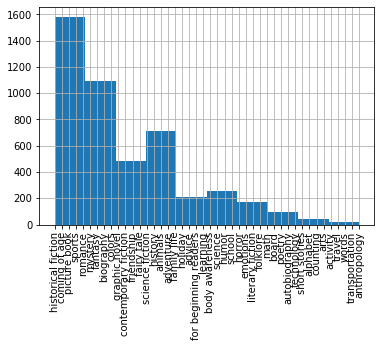

In [48]:
train_data["Genre"].hist(xrot=90);

In [64]:
book_genre_cat = train_data[["Genre"]]
book_genre_encoder = OneHotEncoder()
book_genre_cat_1hot = book_type_encoder.fit_transform(book_genre_cat)
book_genre_df = pd.DataFrame(book_genre_cat_1hot.todense(), 
                             index=train_data.index,
                             columns=book_type_encoder.get_feature_names())

## MinMaxScale Publication Date

In [67]:
book_pub_year = train_data[["Publication date"]]
min_max_scaler = MinMaxScaler()
bp_year_MM = min_max_scaler.fit_transform(book_pub_year)
bp_year_df = pd.DataFrame(data=bp_year_MM,
                          index=train_data.index, 
                          columns=["book_pub_year"])

## Create BOW

In [9]:
#instantiate CountVectorizer()
cv=CountVectorizer(min_df=2)

# this step generates word counts for the words in your docs
word_count_vector=cv.fit_transform(train_data['description'])

In [10]:
# seperate the independent and target variable on training data
train_x = pd.DataFrame(word_count_vector.todense(), columns=cv.get_feature_names())
train_y = train_data['csm_rating']

In [11]:
test_x = pd.DataFrame(cv.transform(test_data['description']).todense(), columns=cv.get_feature_names())
test_y = test_data['csm_rating']

In [12]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.03,
                max_depth = 100, alpha = 1, n_estimators = 500, booster = "gblinear")

In [13]:
#Fit the model with the training data
xg_reg.fit(train_x, train_y)

XGBRegressor(alpha=1, base_score=0.5, booster='gblinear',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.03, max_delta_step=None, max_depth=100,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=None,
             objective='reg:squarederror', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=False, verbosity=None)

In [14]:
#Predict the taget on the train data set
predict_train = xg_reg.predict(train_x)
predict_test = xg_reg.predict(test_x)

In [15]:
mean_absolute_error(train_y, predict_train)

3.282182013281234

In [16]:
mean_absolute_error(test_y, predict_test)

3.276424827444594

### Transform and Predict on the Test DF

In [17]:
#Predict the target on the test dataset
predict_test = xg_reg.predict(test_x)

In [18]:
mean_absolute_error(predict_test, test_y)

3.276424827444594

In [19]:
test_errors = abs(predict_test - test_y)

In [20]:
predictions  = pd.Series(predict_test, index=test_data.index, name="predictions")

In [21]:
test_errors.name = "difference"

In [22]:
test_results = pd.concat([test_data, test_errors, predictions], axis=1)

In [23]:
test_results.head()

,description,csm_rating,difference,predictions
1291,thoughtful sci-fi price beauty.,11,1.838365,9.161635
832,"appealing tale would-be witch laughs, insights.",8,1.161635,9.161635
685,"third bloodlines adventure takes romantic, mag...",13,3.838365,9.161635
5101,teen grapples grief first love charming romance.,12,2.838365,9.161635
2617,another sweet animal tale babe author.,7,2.161635,9.161635


In [24]:
test_results.predictions.unique()

array([9.1616354])